In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.1)


In [50]:
# File maps
price_files = {
    -2: "./round-1-island-data-bottle/prices_round_1_day_-2.csv",
    -1: "./round-1-island-data-bottle/prices_round_1_day_-1.csv",
     0: "./round-1-island-data-bottle/prices_round_1_day_0.csv"
}

trade_files = {
    -2: "./round-1-island-data-bottle/trades_round_1_day_-2.csv",
    -1: "./round-1-island-data-bottle/trades_round_1_day_-1.csv",
     0: "./round-1-island-data-bottle/trades_round_1_day_0.csv"
}

# Load and offset timestamps by 1M steps
OFFSET = 1_000_000
squid_prices_full = []
squid_trades_full = []

for i, (day, pf) in enumerate(price_files.items()):
    df = pd.read_csv(pf, sep=';')
    df = df[df['product'] == 'SQUID_INK'].copy()
    df['timestamp'] += i * OFFSET
    df['day'] = day
    squid_prices_full.append(df)

for i, (day, tf) in enumerate(trade_files.items()):
    df = pd.read_csv(tf, sep=';')
    df = df[df['symbol'] == 'SQUID_INK'].copy()
    df['timestamp'] += i * OFFSET
    df['day'] = day
    squid_trades_full.append(df)

# Combine
squid_prices = pd.concat(squid_prices_full, ignore_index=True).sort_values('timestamp')
squid_trades = pd.concat(squid_trades_full, ignore_index=True).sort_values('timestamp')

len(squid_prices), len(squid_trades)

(30000, 8837)

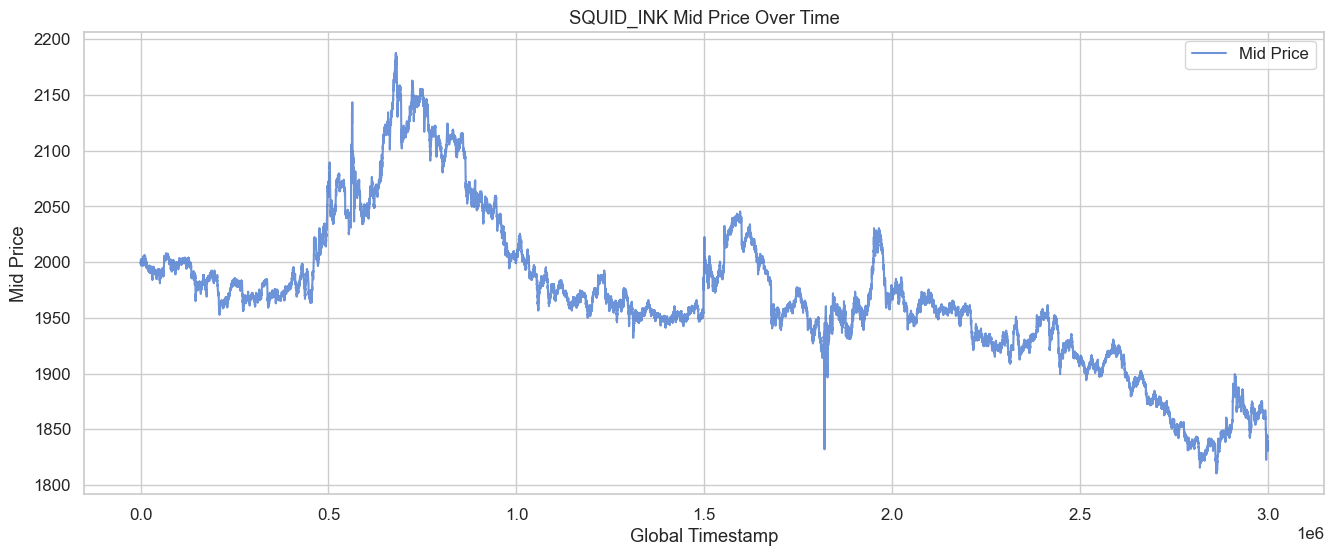

In [51]:
# Mid price over time
squid_prices['mid_price'] = squid_prices['mid_price']

plt.figure(figsize=(16, 6))
plt.plot(squid_prices['timestamp'], squid_prices['mid_price'], label='Mid Price', alpha=0.8)
plt.title('SQUID_INK Mid Price Over Time')
plt.xlabel('Global Timestamp')
plt.ylabel('Mid Price')
plt.legend()
plt.show()


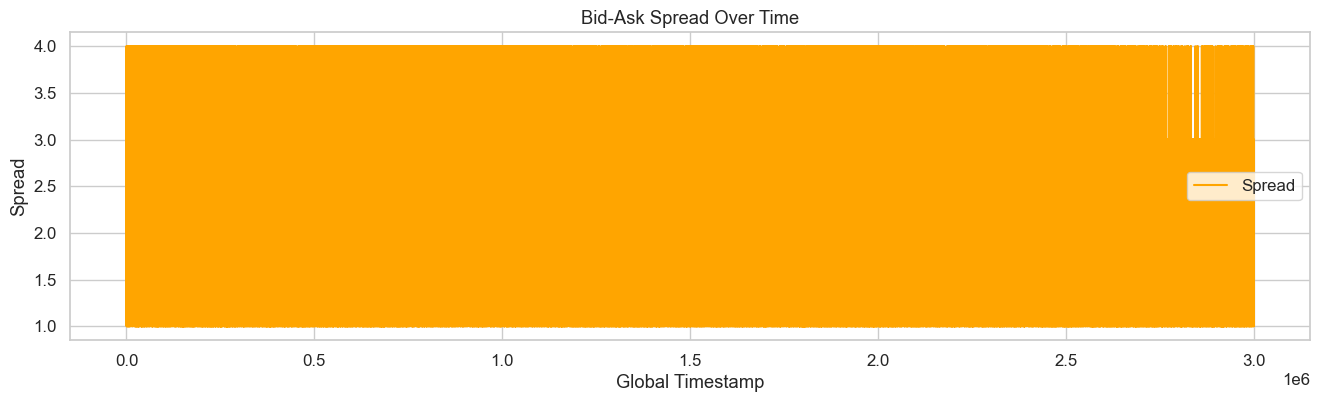

In [52]:
# Spread
squid_prices['spread'] = squid_prices['ask_price_1'] - squid_prices['bid_price_1']

plt.figure(figsize=(16, 4))
plt.plot(squid_prices['timestamp'], squid_prices['spread'], color='orange', label='Spread')
plt.title('Bid-Ask Spread Over Time')
plt.xlabel('Global Timestamp')
plt.ylabel('Spread')
plt.legend()
plt.show()

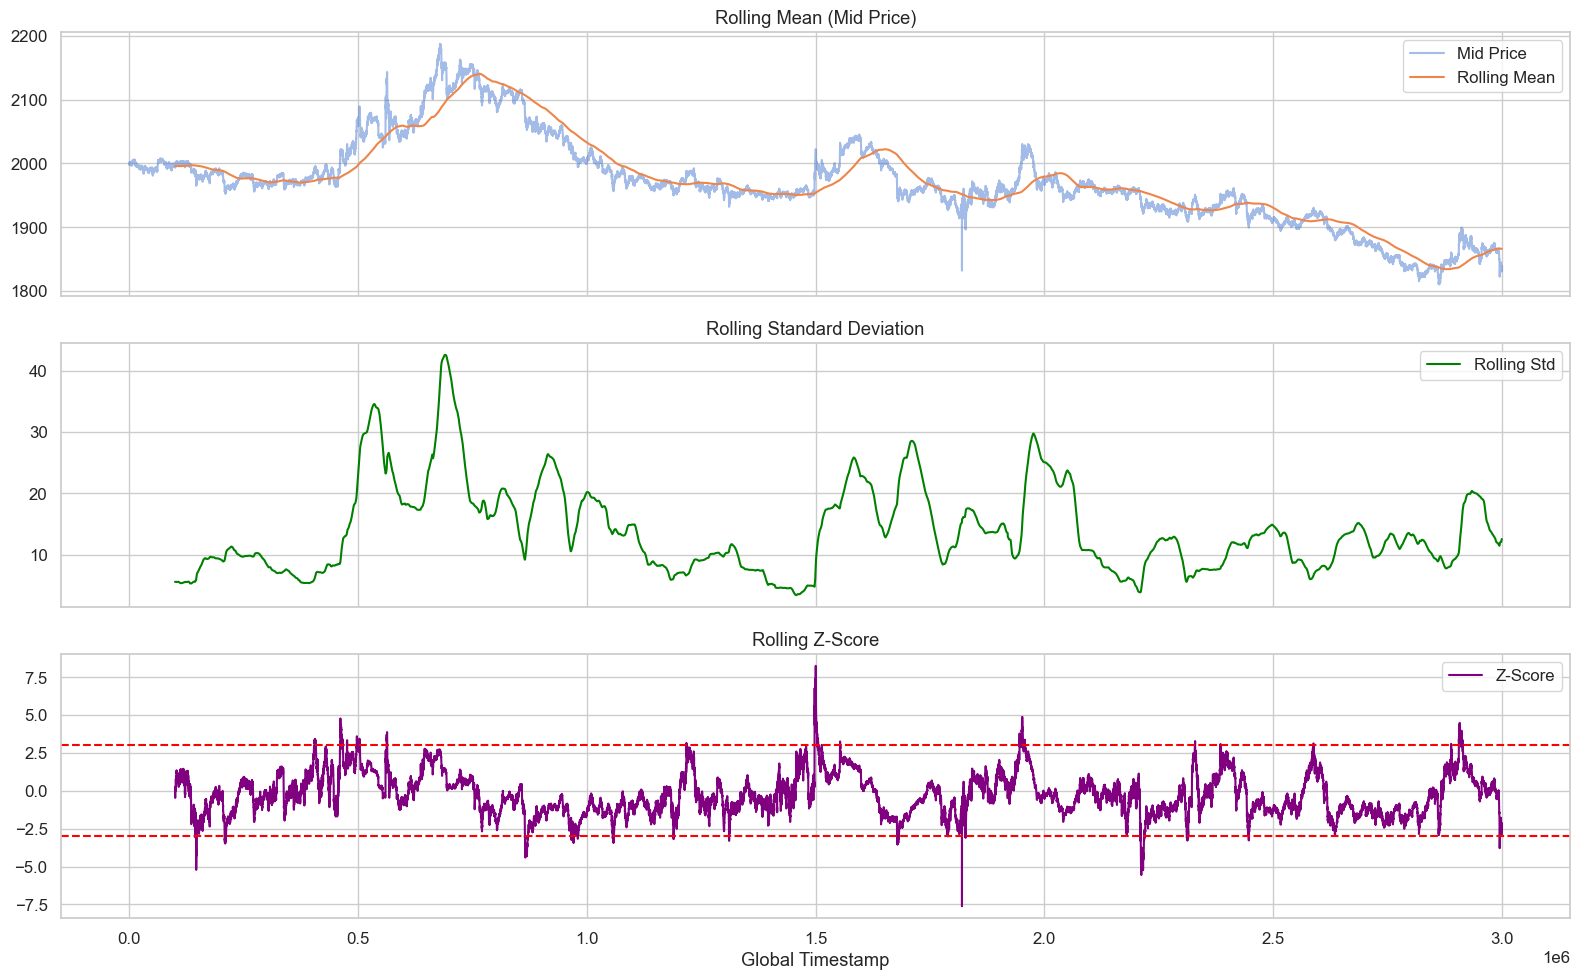

In [53]:
# Rolling stats
WINDOW = 1000
squid_prices['rolling_mean'] = squid_prices['mid_price'].rolling(WINDOW).mean()
squid_prices['rolling_std'] = squid_prices['mid_price'].rolling(WINDOW).std()
squid_prices['z_score'] = (squid_prices['mid_price'] - squid_prices['rolling_mean']) / squid_prices['rolling_std']


fig, axs = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

# plot rolling mean, atop of price
axs[0].plot(squid_prices['timestamp'], squid_prices['mid_price'], label='Mid Price', alpha=0.5)
axs[0].plot(squid_prices['timestamp'], squid_prices['rolling_mean'], label='Rolling Mean')
axs[0].set_title('Rolling Mean (Mid Price)')
axs[0].legend()

axs[1].plot(squid_prices['timestamp'], squid_prices['rolling_std'], label='Rolling Std', color='green')
axs[1].set_title('Rolling Standard Deviation')
axs[1].legend()

axs[2].plot(squid_prices['timestamp'], squid_prices['z_score'], label='Z-Score', color='purple')
axs[2].axhline(3, color='red', linestyle='--')
axs[2].axhline(-3, color='red', linestyle='--')
axs[2].set_title('Rolling Z-Score')
axs[2].legend()

plt.xlabel('Global Timestamp')
plt.tight_layout()
plt.show()


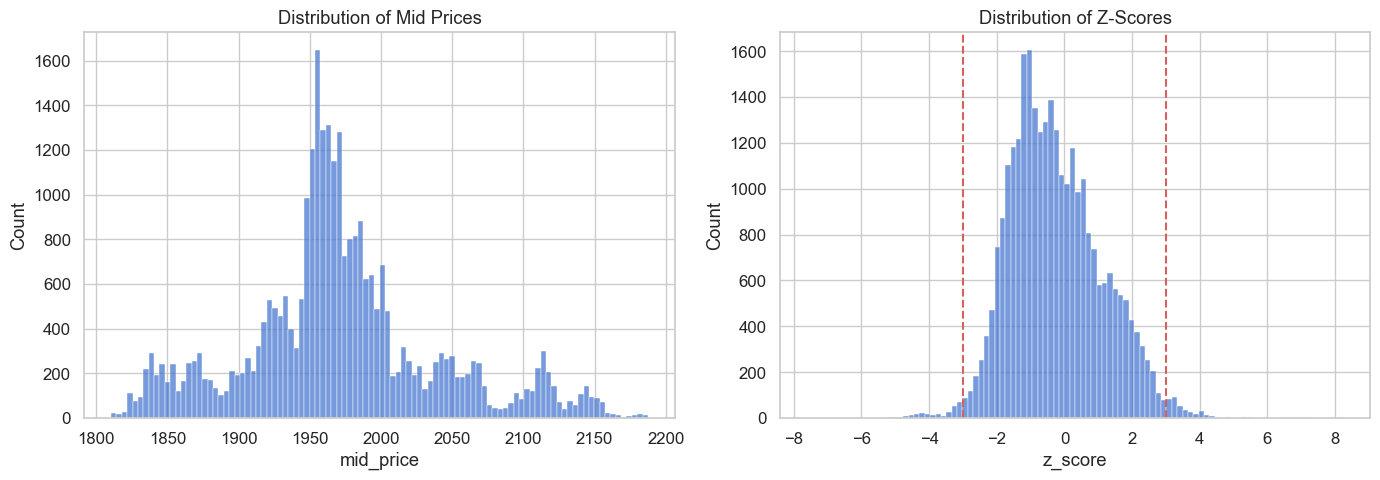

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(squid_prices['mid_price'], bins=100, ax=axs[0])
axs[0].set_title("Distribution of Mid Prices")

sns.histplot(squid_prices['z_score'].dropna(), bins=100, ax=axs[1])
axs[1].axvline(3, color='r', linestyle='--')
axs[1].axvline(-3, color='r', linestyle='--')
axs[1].set_title("Distribution of Z-Scores")

plt.tight_layout()
plt.show()


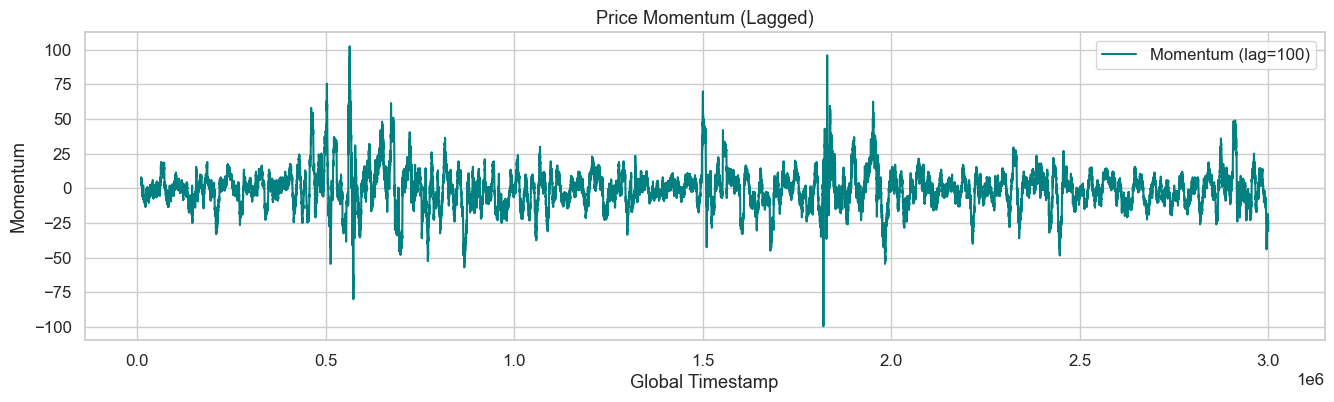

In [55]:
# Momentum = price(t) - price(t - lag)
LAG = 100
squid_prices['momentum'] = squid_prices['mid_price'] - squid_prices['mid_price'].shift(LAG)

plt.figure(figsize=(16, 4))
plt.plot(squid_prices['timestamp'], squid_prices['momentum'], label=f'Momentum (lag={LAG})', color='teal')
plt.title('Price Momentum (Lagged)')
plt.xlabel('Global Timestamp')
plt.ylabel('Momentum')
plt.legend()
plt.show()


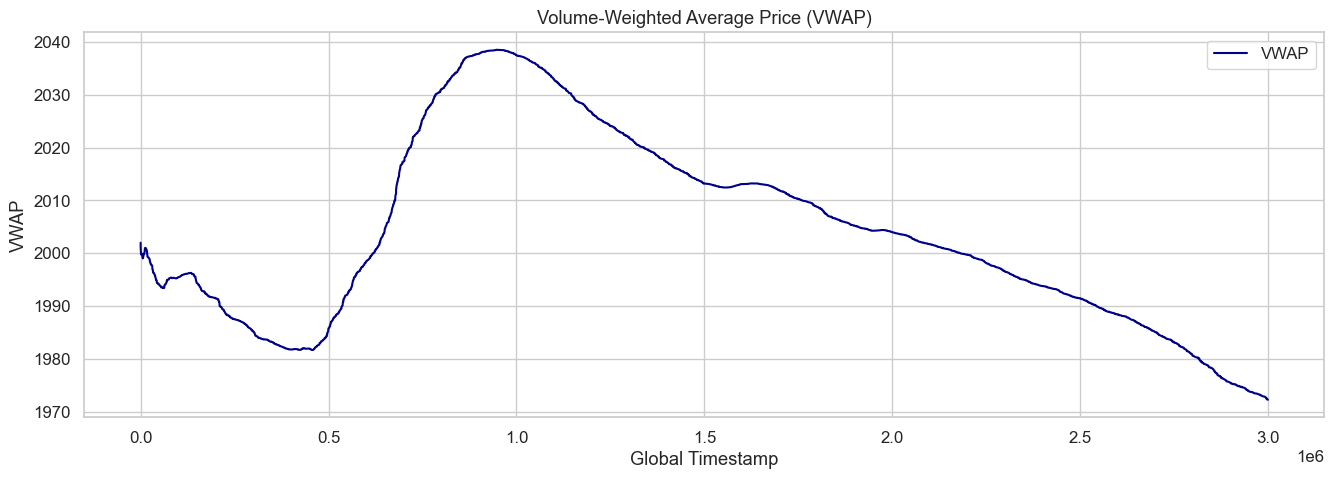

In [56]:
# VWAP from trade data
squid_trades['vwap_price'] = squid_trades['price'] * squid_trades['quantity']
squid_trades['vwap'] = squid_trades['vwap_price'].cumsum() / squid_trades['quantity'].cumsum()

plt.figure(figsize=(16, 5))
plt.plot(squid_trades['timestamp'], squid_trades['vwap'], label='VWAP', color='darkblue')
plt.title('Volume-Weighted Average Price (VWAP)')
plt.xlabel('Global Timestamp')
plt.ylabel('VWAP')
plt.legend()
plt.show()


C:\Users\nirav\AppData\Local\Temp\ipykernel_62500\1471084620.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  z_return_summary = squid_prices.groupby('z_bin')['forward_return'].mean().reset_index()
C:\Users\nirav\AppData\Local\Temp\ipykernel_62500\1471084620.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='z_bin', y='forward_return', data=z_return_summary, palette='coolwarm')


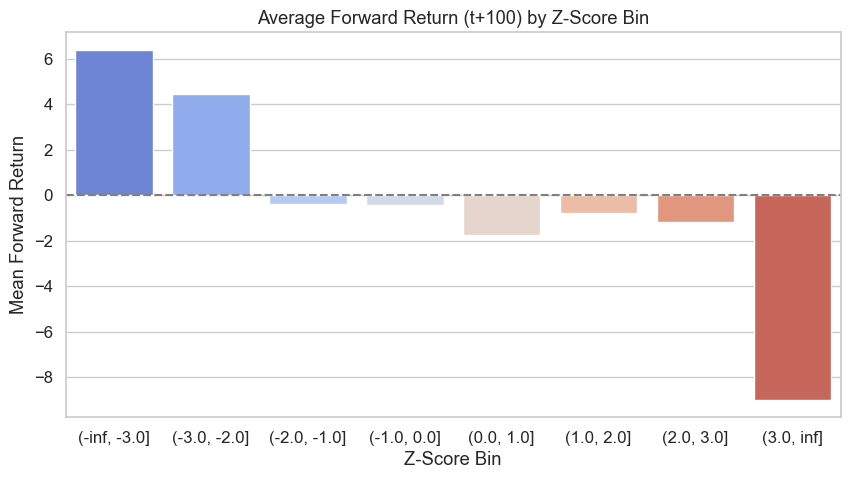

In [57]:
# Forward returns: 100 steps ahead
FWD = 100
squid_prices['future_price'] = squid_prices['mid_price'].shift(-FWD)
squid_prices['forward_return'] = squid_prices['future_price'] - squid_prices['mid_price']

# Bin z-scores
z_bins = [-np.inf, -3, -2, -1, 0, 1, 2, 3, np.inf]
squid_prices['z_bin'] = pd.cut(squid_prices['z_score'], bins=z_bins)

# Average return per z-bin
z_return_summary = squid_prices.groupby('z_bin')['forward_return'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x='z_bin', y='forward_return', data=z_return_summary, palette='coolwarm')
plt.title(f'Average Forward Return (t+{FWD}) by Z-Score Bin')
plt.xlabel('Z-Score Bin')
plt.ylabel('Mean Forward Return')
plt.axhline(0, color='gray', linestyle='--')
plt.show()


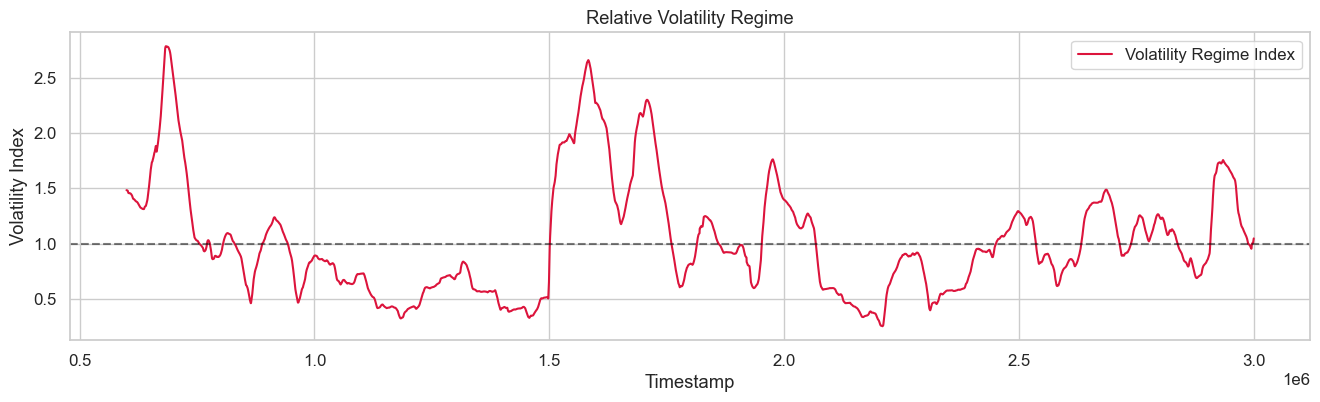

In [58]:
# Volatility regime = rolling_std / its own rolling mean
VOL_WINDOW = 5000
squid_prices['volatility_regime'] = squid_prices['rolling_std'] / squid_prices['rolling_std'].rolling(VOL_WINDOW).mean()

plt.figure(figsize=(16, 4))
plt.plot(squid_prices['timestamp'], squid_prices['volatility_regime'], label='Volatility Regime Index', color='crimson')
plt.axhline(1, linestyle='--', color='black', alpha=0.5)
plt.title('Relative Volatility Regime')
plt.xlabel('Timestamp')
plt.ylabel('Volatility Index')
plt.legend()
plt.show()


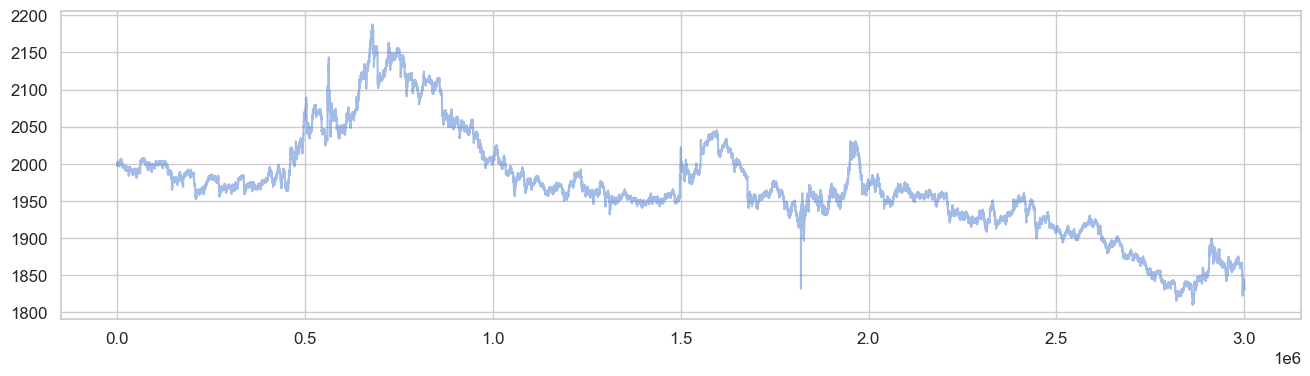

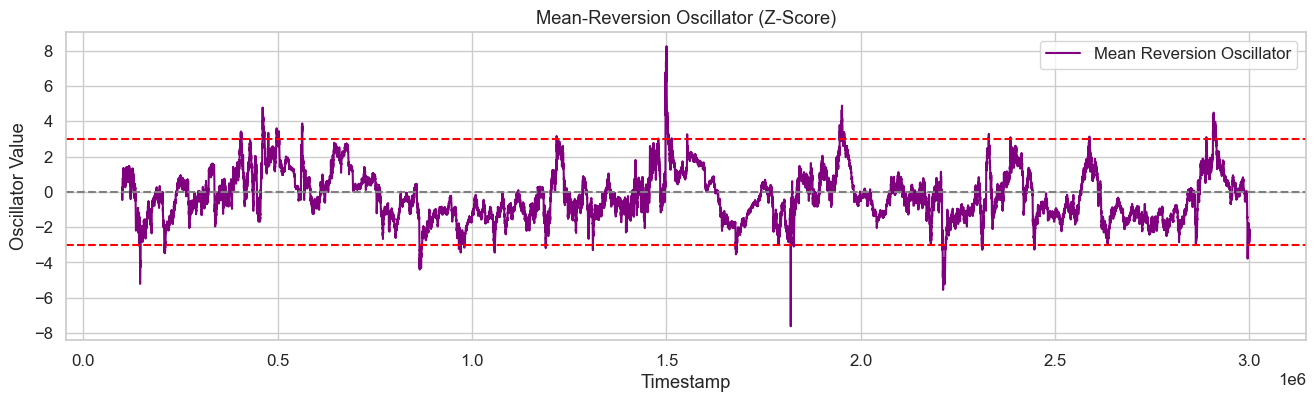

In [62]:
# Mean-reversion signal = normalized deviation from mean
squid_prices['oscillator'] = (squid_prices['mid_price'] - squid_prices['rolling_mean']) / squid_prices['rolling_std']


# plot oscillator and mid price on different graphs
plt.figure(figsize=(16, 4))
plt.plot(squid_prices['timestamp'], squid_prices['mid_price'], label='Mid Price', alpha=0.5)

plt.figure(figsize=(16, 4))
plt.plot(squid_prices['timestamp'], squid_prices['oscillator'], label='Mean Reversion Oscillator', color='purple')
plt.axhline(0, color='gray', linestyle='--')
plt.axhline(3, color='red', linestyle='--')
plt.axhline(-3, color='red', linestyle='--')
plt.title('Mean-Reversion Oscillator (Z-Score)')
plt.xlabel('Timestamp')
plt.ylabel('Oscillator Value')
plt.legend()
plt.show()


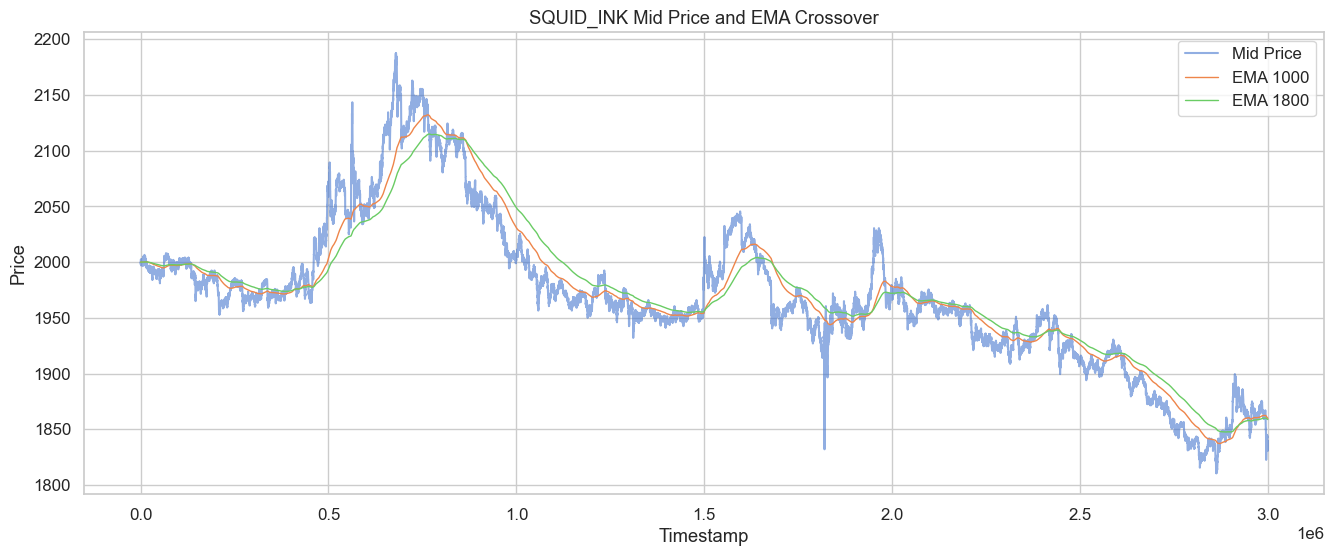

In [98]:
SHORT_WINDOW = 1000
LONG_WINDOW = 1800

squid_prices['ema_short'] = squid_prices['mid_price'].ewm(span=SHORT_WINDOW, adjust=False).mean()
squid_prices['ema_long'] = squid_prices['mid_price'].ewm(span=LONG_WINDOW, adjust=False).mean()
squid_prices['ema_crossover'] = squid_prices['ema_short'] - squid_prices['ema_long']

plt.figure(figsize=(16, 6))
plt.plot(squid_prices['timestamp'], squid_prices['mid_price'], label='Mid Price', alpha=0.6)
plt.plot(squid_prices['timestamp'], squid_prices['ema_short'], label=f'EMA {SHORT_WINDOW}', linewidth=1)
plt.plot(squid_prices['timestamp'], squid_prices['ema_long'], label=f'EMA {LONG_WINDOW}', linewidth=1)
plt.title('SQUID_INK Mid Price and EMA Crossover')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.legend()
plt.show()

In [99]:
# Calculate the difference between short and long EMAs
squid_prices['ema_diff'] = squid_prices['ema_short'] - squid_prices['ema_long']

# Detect crossover points
squid_prices['signal'] = 0
squid_prices.loc[squid_prices['ema_diff'] > 0, 'signal'] = 1
squid_prices.loc[squid_prices['ema_diff'] < 0, 'signal'] = -1

# Detect signal change (actual cross)
squid_prices['signal_shift'] = squid_prices['signal'].shift(1)
squid_prices['crossover'] = (squid_prices['signal'] != squid_prices['signal_shift'])

# Keep only crossover rows
crossovers = squid_prices[squid_prices['crossover'] & squid_prices['signal'] != 0]
print(f"Total crossovers detected: {len(crossovers)}")

Total crossovers detected: 16


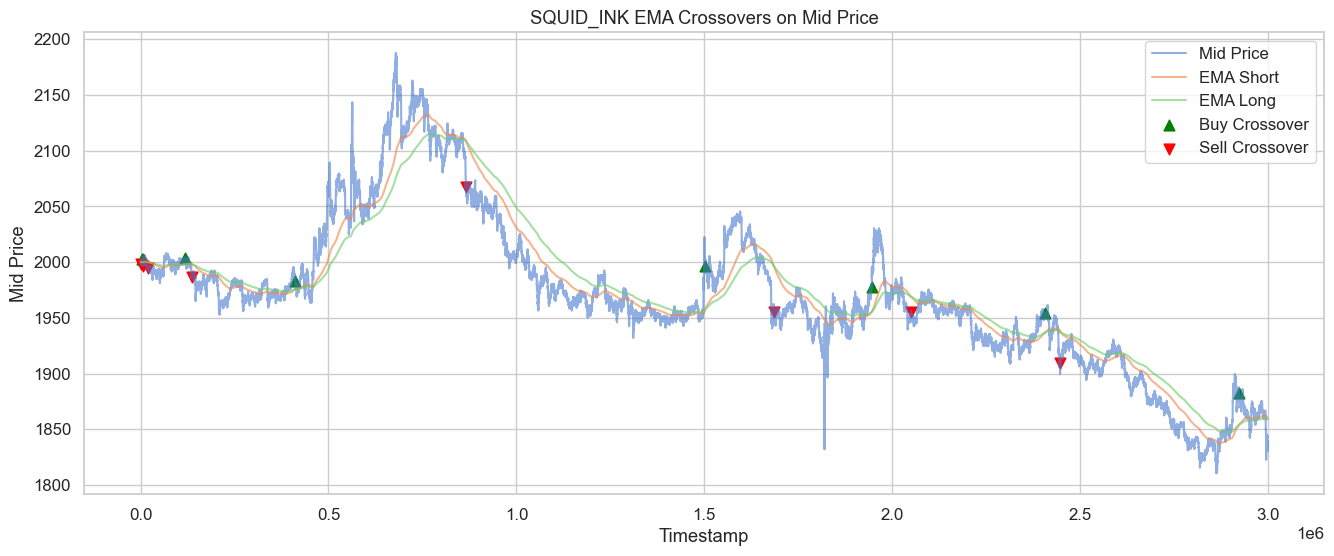

In [100]:
plt.figure(figsize=(16, 6))
plt.plot(squid_prices['timestamp'], squid_prices['mid_price'], label='Mid Price', alpha=0.6)
plt.plot(squid_prices['timestamp'], squid_prices['ema_short'], label='EMA Short', alpha=0.6)
plt.plot(squid_prices['timestamp'], squid_prices['ema_long'], label='EMA Long', alpha=0.6)

# Highlight crossover points
buy_cross = crossovers[crossovers['signal'] == 1]
sell_cross = crossovers[crossovers['signal'] == -1]

plt.scatter(buy_cross['timestamp'], buy_cross['mid_price'], color='green', label='Buy Crossover', marker='^', s=60)
plt.scatter(sell_cross['timestamp'], sell_cross['mid_price'], color='red', label='Sell Crossover', marker='v', s=60)

plt.title('SQUID_INK EMA Crossovers on Mid Price')
plt.xlabel('Timestamp')
plt.ylabel('Mid Price')
plt.legend()
plt.show()


In [82]:
FWD_HORIZON = 100

# For each crossover, calculate future return
def calculate_forward_return(row):
    future_idx = row.name + FWD_HORIZON
    if future_idx < len(squid_prices):
        future_price = squid_prices.iloc[future_idx]['mid_price']
        return future_price - row['mid_price']
    return np.nan

crossovers['forward_return'] = crossovers.apply(calculate_forward_return, axis=1)

# Split by signal
bullish = crossovers[crossovers['signal'] == 1]
bearish = crossovers[crossovers['signal'] == -1]

print("Average forward return after BUY crossover:", bullish['forward_return'].mean())
print("Average forward return after SELL crossover:", bearish['forward_return'].mean())


Average forward return after BUY crossover: -1.9444444444444444
Average forward return after SELL crossover: 2.3333333333333335


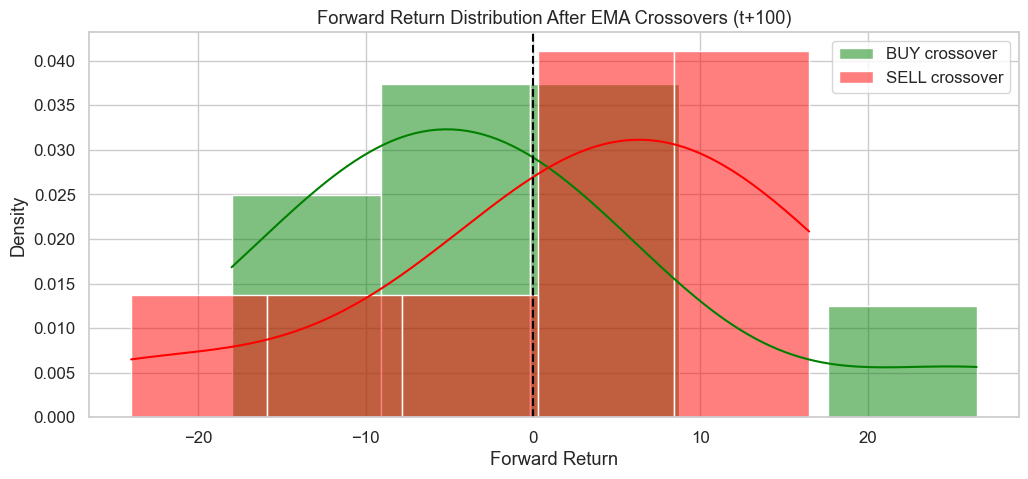

In [83]:
plt.figure(figsize=(12, 5))
sns.histplot(bullish['forward_return'].dropna(), color='green', kde=True, label='BUY crossover', stat='density')
sns.histplot(bearish['forward_return'].dropna(), color='red', kde=True, label='SELL crossover', stat='density')
plt.axvline(0, linestyle='--', color='black')
plt.title(f'Forward Return Distribution After EMA Crossovers (t+{FWD_HORIZON})')
plt.xlabel('Forward Return')
plt.ylabel('Density')
plt.legend()
plt.show()


Mean forward return after LONG entry: 38.0
Mean forward return after SHORT entry: 17.4


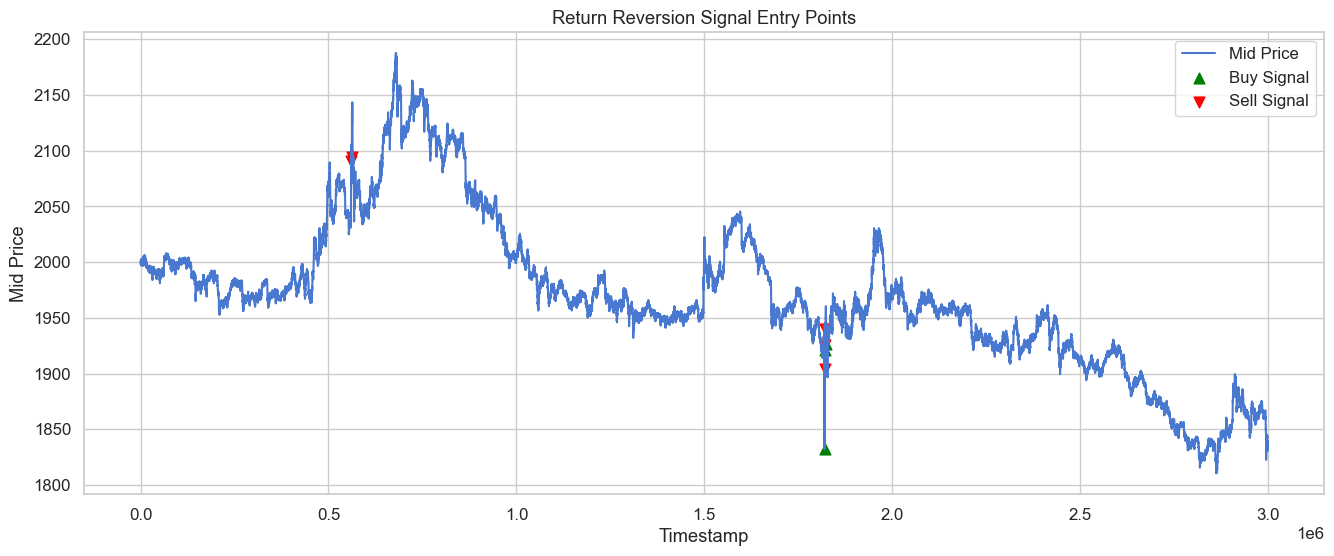

In [108]:
# Look at returns over last 10 and 20 ticks
squid_prices['ret_10'] = squid_prices['mid_price'].pct_change(periods=1)
squid_prices['ret_20'] = squid_prices['mid_price'].pct_change(periods=20)

# Entry signal: extreme short-term return
squid_prices['entry_signal'] = 0
squid_prices.loc[squid_prices['ret_10'] > 0.01, 'entry_signal'] = -1  # short
squid_prices.loc[squid_prices['ret_10'] < -0.01, 'entry_signal'] = 1  # long

# Capture signal timestamps
return_entries = squid_prices[squid_prices['entry_signal'] != 0].copy()

# Compute future return over next 30 ticks
FWD = 30
def forward_ret(row):
    idx = row.name + FWD
    if idx < len(squid_prices):
        return squid_prices.iloc[idx]['mid_price'] - row['mid_price']
    return np.nan

return_entries['forward_return'] = return_entries.apply(forward_ret, axis=1)

# Analyze returns by entry type
print("Mean forward return after LONG entry:", return_entries[return_entries['entry_signal'] == 1]['forward_return'].mean())
print("Mean forward return after SHORT entry:", return_entries[return_entries['entry_signal'] == -1]['forward_return'].mean())

plt.figure(figsize=(16, 6))
plt.plot(squid_prices['timestamp'], squid_prices['mid_price'], label='Mid Price')

buy_pts = return_entries[return_entries['entry_signal'] == 1]
sell_pts = return_entries[return_entries['entry_signal'] == -1]

plt.scatter(buy_pts['timestamp'], buy_pts['mid_price'], color='green', marker='^', label='Buy Signal', s=60)
plt.scatter(sell_pts['timestamp'], sell_pts['mid_price'], color='red', marker='v', label='Sell Signal', s=60)

plt.title('Return Reversion Signal Entry Points')
plt.xlabel('Timestamp')
plt.ylabel('Mid Price')
plt.legend()
plt.show()


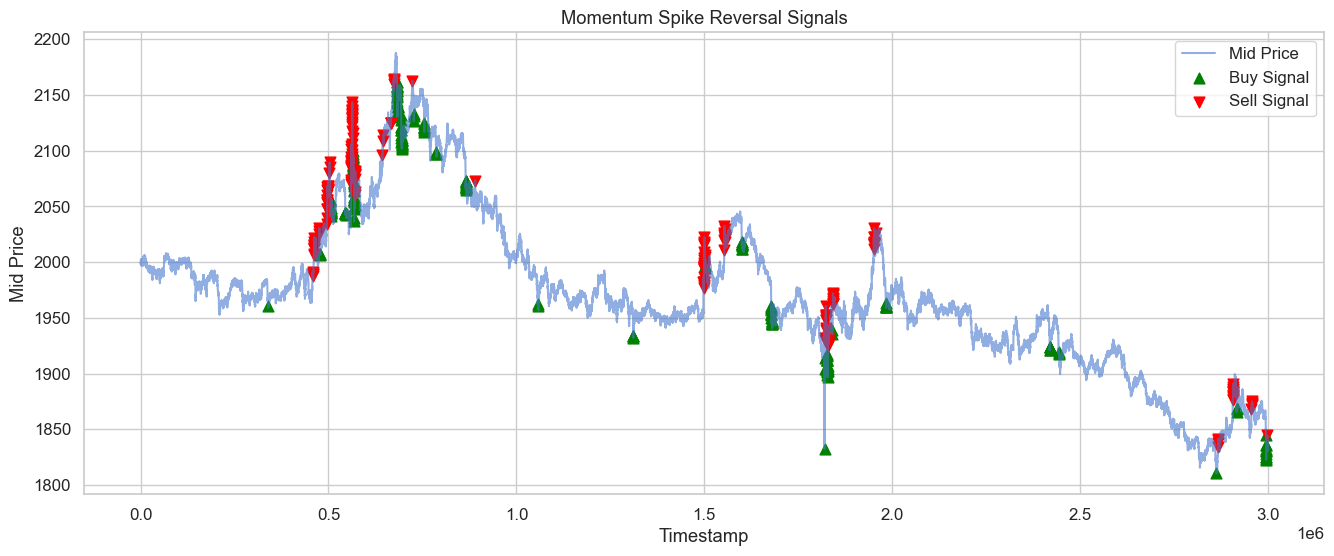

In [ ]:
# Set params
LAG = 10
THRESH = 10  # adjust based on price scale

squid_prices['momentum'] = squid_prices['mid_price'] - squid_prices['mid_price'].shift(LAG)
squid_prices['signal'] = 0
squid_prices.loc[squid_prices['momentum'] > THRESH, 'signal'] = -1  # short
squid_prices.loc[squid_prices['momentum'] < -THRESH, 'signal'] = 1  # long



In [119]:
FWD = 5  # hold duration

def forward_return(row):
    future_idx = row.name + FWD
    if future_idx < len(squid_prices):
        return squid_prices.iloc[future_idx]['mid_price'] - row['mid_price']
    return np.nan

momentum_signals = squid_prices[squid_prices['signal'] != 0].copy()
momentum_signals['forward_return'] = momentum_signals.apply(forward_return, axis=1)

print("Mean return after long (reversal buy):", momentum_signals[momentum_signals['signal'] == 1]['forward_return'].mean())
print("Mean return after short (reversal sell):", momentum_signals[momentum_signals['signal'] == -1]['forward_return'].mean())


Mean return after long (reversal buy): 0.13814616755793227
Mean return after short (reversal sell): 0.6078886310904872


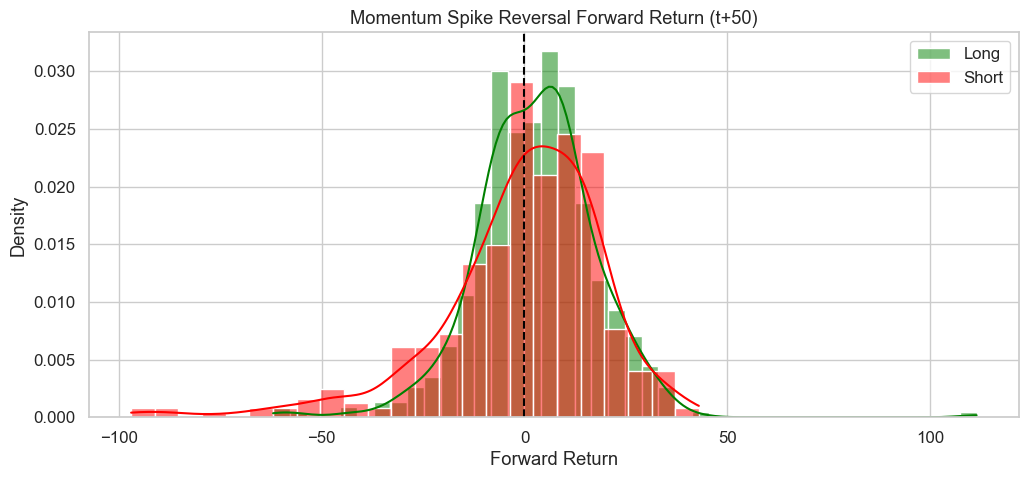

In [111]:
plt.figure(figsize=(12, 5))
sns.histplot(momentum_signals[momentum_signals['signal'] == 1]['forward_return'].dropna(), label='Long', color='green', kde=True, stat='density')
sns.histplot(momentum_signals[momentum_signals['signal'] == -1]['forward_return'].dropna(), label='Short', color='red', kde=True, stat='density')
plt.axvline(0, linestyle='--', color='black')
plt.title('Momentum Spike Reversal Forward Return (t+50)')
plt.xlabel('Forward Return')
plt.ylabel('Density')
plt.legend()
plt.show()


In [112]:
def simulate_exit_signals(df, entry_indices, signal_type='momentum', lag=10, momentum_exit_threshold=3, max_hold=100):
    exits = []

    for idx in entry_indices:
        entry_price = df.iloc[idx]['mid_price']
        entry_time = df.iloc[idx]['timestamp']
        side = df.iloc[idx]['signal']  # 1 for long, -1 for short
        direction = 'long' if side == 1 else 'short'
        
        for i in range(1, max_hold):
            if idx + i >= len(df): break

            curr_row = df.iloc[idx + i]
            curr_price = curr_row['mid_price']
            curr_mean = df['mid_price'].rolling(lag).mean().iloc[idx + i]
            curr_momentum = df['mid_price'].diff(lag).iloc[idx + i]

            # Exit conditions
            revert_to_mean = (direction == 'long' and curr_price >= curr_mean) or \
                             (direction == 'short' and curr_price <= curr_mean)
            
            fade_momentum = abs(curr_momentum) < momentum_exit_threshold
            
            if revert_to_mean or fade_momentum:
                exit_price = curr_price
                return_pct = (exit_price - entry_price) * side
                exits.append(return_pct)
                break
        else:
            # fallback exit after max_hold
            final_price = df.iloc[min(idx + max_hold, len(df)-1)]['mid_price']
            exits.append((final_price - entry_price) * side)
    
    return exits


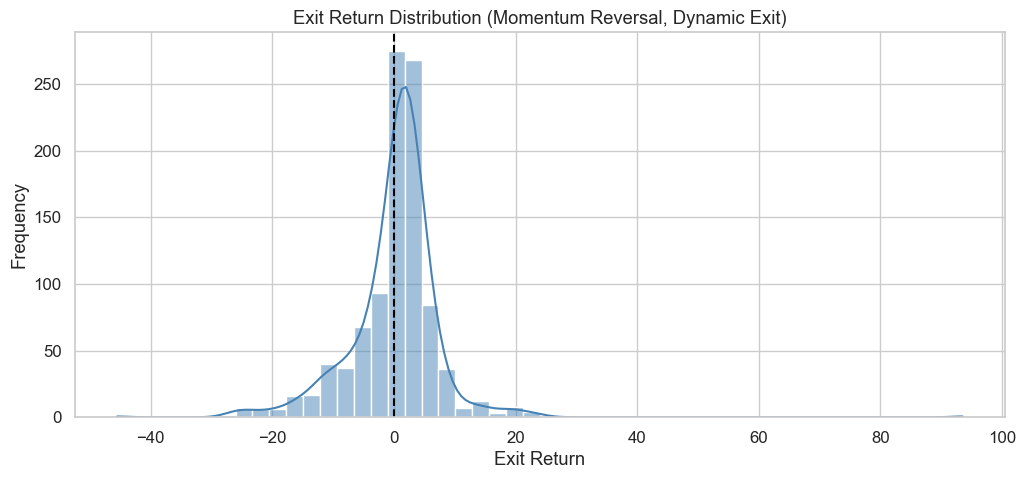

Average return per trade: 0.09727822580645161
Win rate: 0.59375


In [113]:
momentum_entries = squid_prices[squid_prices['signal'] != 0].copy()
momentum_exit_returns = simulate_exit_signals(squid_prices, momentum_entries.index, signal_type='momentum')

# Plot return distribution
plt.figure(figsize=(12, 5))
sns.histplot(momentum_exit_returns, bins=50, kde=True, color='steelblue')
plt.axvline(0, linestyle='--', color='black')
plt.title('Exit Return Distribution (Momentum Reversal, Dynamic Exit)')
plt.xlabel('Exit Return')
plt.ylabel('Frequency')
plt.show()

print("Average return per trade:", np.mean(momentum_exit_returns))
print("Win rate:", np.mean(np.array(momentum_exit_returns) > 0))


In [120]:
def simulate_trailing_stop_exit(df, entry_indices, trailing_stop=10, max_hold=100, lag=10):
    exits = []

    for idx in entry_indices:
        entry_price = df.iloc[idx]['mid_price']
        side = df.iloc[idx]['signal']  # 1 for long, -1 for short
        direction = 'long' if side == 1 else 'short'
        
        best_price = entry_price  # max favorable move
        for i in range(1, max_hold):
            if idx + i >= len(df): break
            curr_price = df.iloc[idx + i]['mid_price']

            # Update best favorable price
            if direction == 'long':
                best_price = max(best_price, curr_price)
                if best_price - curr_price >= trailing_stop:
                    exits.append((curr_price - entry_price) * side)
                    break
            else:
                best_price = min(best_price, curr_price)
                if curr_price - best_price >= trailing_stop:
                    exits.append((curr_price - entry_price) * side)
                    break
        else:
            # fallback exit after max_hold
            final_price = df.iloc[min(idx + max_hold, len(df)-1)]['mid_price']
            exits.append((final_price - entry_price) * side)

    return exits


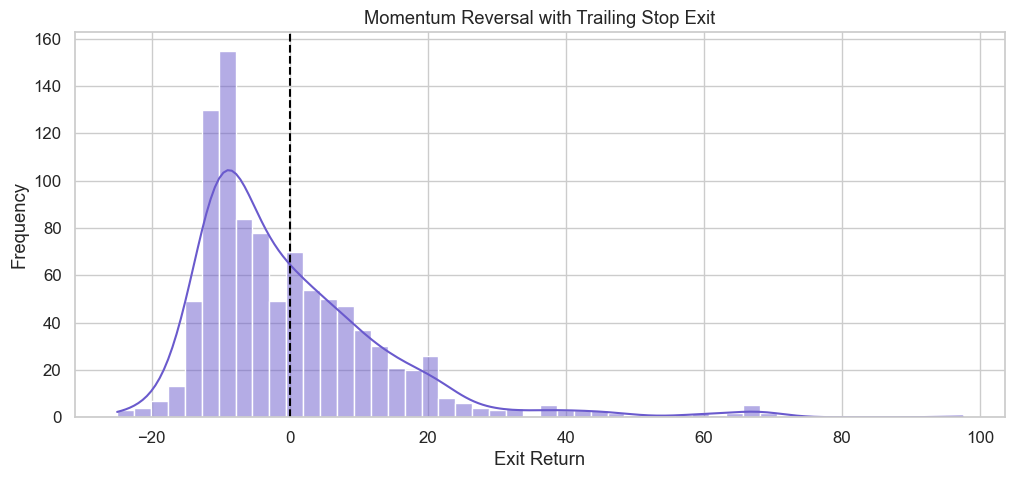

Average return per trade: 0.16480162767039674
Win rate: 0.38351983723296035


In [121]:
# Assuming 'signal' column already flags momentum-based entry signals
momentum_entries = squid_prices[squid_prices['signal'] != 0].copy()

# Simulate with a trailing stop of 10 points
trailing_returns = simulate_trailing_stop_exit(
    df=squid_prices,
    entry_indices=momentum_entries.index,
    trailing_stop=10,
    max_hold=100
)

# Plot distribution
plt.figure(figsize=(12, 5))
sns.histplot(trailing_returns, bins=50, kde=True, color='slateblue')
plt.axvline(0, linestyle='--', color='black')
plt.title('Momentum Reversal with Trailing Stop Exit')
plt.xlabel('Exit Return')
plt.ylabel('Frequency')
plt.show()

print("Average return per trade:", np.mean(trailing_returns))
print("Win rate:", np.mean(np.array(trailing_returns) > 0))
